# **MOD510: Project4**

What can we learn about a system if we inject a tracer and measure the outlet concentration as a function of time?

**MOD510: Project 4**

Date: **December 1st 2025**

Names: **Malvin Varpe & Torgrim Odde**

## **Introduction**  
Mixing tanks are fundamental components in chemical and environmental engineering. They are often used to model processes such as chemical reactions, heat
transfer, and pollutant dispersion. In this exercise, we will model a system of
interconnected mixing tanks using a stochastic modeling approach based on
Monte Carlo methods. Beginning with a single tank, you will progressively
model a three-tank system, incorporating uncertainty estimation and validating
results against ordinary differential equation (ODE) solutions.



## Exercise 1: Stochastic modeling of mixing tanks  

## Exercise 2: Spreading of contaminants in underground aquifers using random walk  
### Part 1. 2D Random Walk Model  
**1. Basic Model:**   
*Initialize 1000 particles positioned on a square grid centered at (1000, 1000)(Figure 2).*    
• *At each time step, move (or don’t move) each particle one integer step in the x and y directions. No diagonal walking should be allowed.*    
• *Ensure that if a particle’s movement takes it beyond the predefined boundary of the space (0 ≤ x ≤ 2000, 0 ≤ y ≤ 2000; Figure 2), the simulation stops.*

In [53]:

import numpy as np
import matplotlib.pyplot as plt

def start_pos_f(n = 1000, start_pos=(1000,1000)):
    start_pos = np.array(start_pos)
    pos = np.ones((n, 2)) * start_pos
    return pos

def one_step(arr):
    directions = np.random.randint(0, 5, size=len(arr))

    dx = np.array([0, 1, -1, 0, 0])
    dy = np.array([0, 0, 0, 1, -1])
    arr += np.stack([dx[directions], dy[directions]], axis=1)
    return arr

def rndm_walk_plain(n_steps, n_walkers=1000, lower_bound=0, higher_bound=2000):
    k=0
    pos = start_pos_f(n_walkers)
    for _ in range(n_steps):
        pos = one_step(pos)
        k+=1 
        if np.any(pos <= lower_bound) or np.any(pos >= higher_bound):
            return pos, k
        
    return pos, k

def plot_positions_matplotlib(array, title, xlim=(0, 2000), ylim=(0, 2000), start_pos=(1000, 1000)):
    
    
    mask = (
        (array[:, 0] == xlim[0]) | (array[:, 0] == xlim[1]) |
        (array[:, 1] == ylim[0]) | (array[:, 1] == ylim[1])
    )

    boundary_points = array[mask]


    plt.figure(figsize=(8, 8))
    plt.scatter(array[:,0], array[:,1], color='blue', s=50, label = 'End points')  # s = dot size
    plt.scatter(start_pos[0], start_pos[1], color='red', s=100, label='Start position')  # Start position in red
    plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='green', s=100, label='Boundary point(s)')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [55]:
pos, k = rndm_walk_plain(n_steps=1000000, n_walkers=1000, lower_bound=0, higher_bound=2000)

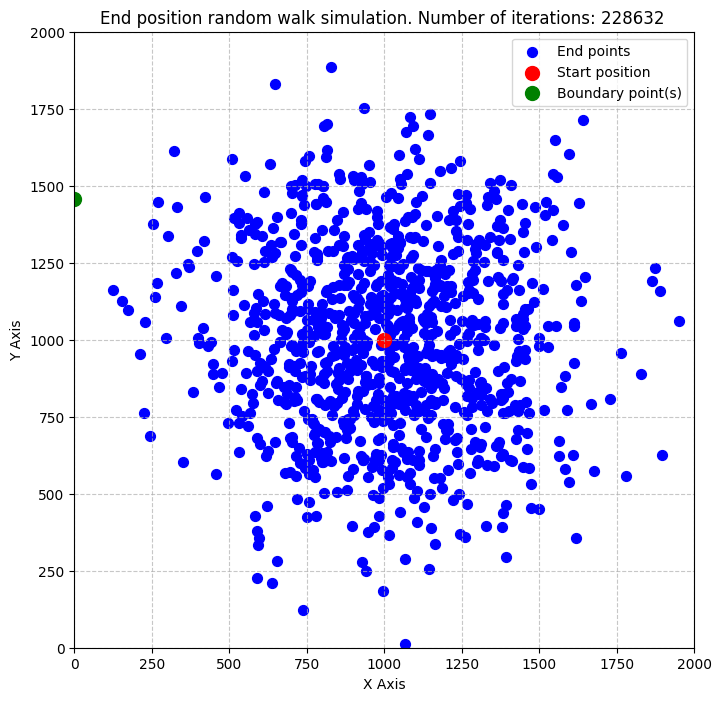

In [56]:
plot_positions_matplotlib(pos,title=f"End position random walk simulation. Number of iterations: {k} ")

**2. Probability-Weighted Movement:**  
*Modify the program to define different probabilities for a particle moving (or not) in the x and y directions. In 2D, there should be atotal of nine possible movement directions, including staying in place. Each movement is associated with a defined probability.* 
• *Verify that the sum of all movement probabilities equals 1.*  
  
Assuming that we now can move diagonally.

In [57]:
def one_step_mod(
        arr,
        p_ss=1/9, #0
        p_ps=1/9, #1
        p_sp=1/9, #2
        p_pp=1/9, #3
        p_ns=1/9, #4
        p_sn=1/9, #5
        p_nn=1/9, #6
        p_np=1/9, #7
        p_pn=1/9  #8
                 ):
        
        p = [p_ss, p_ps, p_sp, p_pp, p_ns, p_sn, p_nn, p_np, p_pn]


        directions = np.random.choice(9, size=len(arr), p=p)
        dx = np.array([0, 1, 0, 1, -1, 0, -1, -1, 1])
        dy = np.array([0, 0, 1, 1, 0, -1, -1, 1, -1])
        arr += np.stack([dx[directions], dy[directions]], axis=1)
        return arr


def rndm_walk_mod(n_steps, n_walkers=1000, lower_bound=0, higher_bound=2000, start_pos=(1000,1000),
        p_ss=1/9, #0
        p_ps=1/9, #1
        p_sp=1/9, #2
        p_pp=1/9, #3
        p_ns=1/9, #4
        p_sn=1/9, #5
        p_nn=1/9, #6
        p_np=1/9, #7
        p_pn=1/9  #8
                  ):
    p = [p_ss, p_ps, p_sp, p_pp, p_ns, p_sn, p_nn, p_np, p_pn]
    
    if not np.isclose(sum(p), 1.0, atol=1e-8):
        raise ValueError(f"Probabilities must sum to 1. Current sum: {sum(p)}")

    k=0
    pos = start_pos_f(n_walkers, start_pos)
    for _ in range(n_steps):
        pos = one_step_mod(pos, *p)
        k+=1 
        if np.any(pos <= lower_bound) or np.any(pos >= higher_bound):
            return pos, k
        
    return pos, k

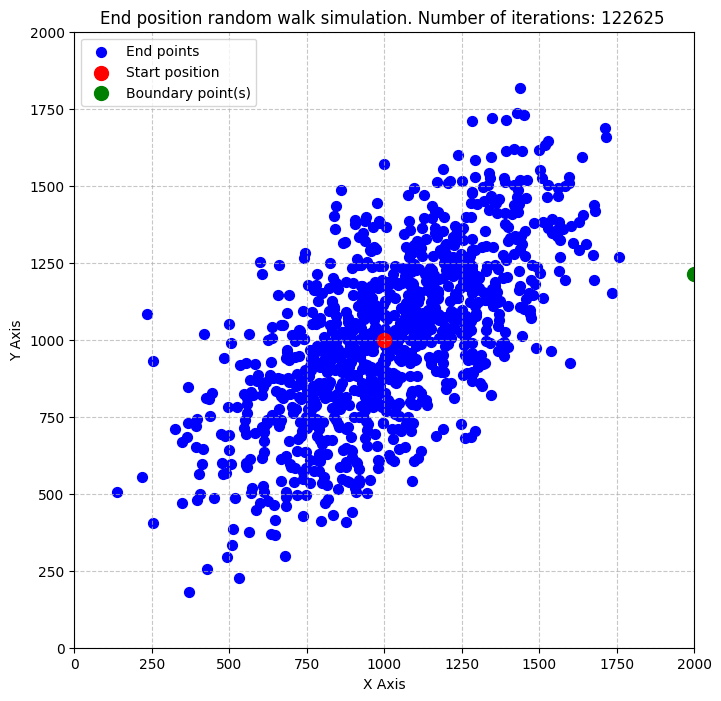

In [58]:
pos, k = rndm_walk_mod(n_steps=1000000, n_walkers=1000, lower_bound=0, higher_bound=2000, p_pp=2/9,p_pn=0, p_nn=2/9 ,p_np=0)
plot_positions_matplotlib(pos,title=f"End position random walk simulation. Number of iterations: {k} ")

### Part 2. 2D Random Walk Model of Contaminant Transportin Aquifers  
**Description:** *Simulate the spread of contaminants in an aquifer using a random walk model and assess contamination risk at varying distances from the source.*   
1. **Define Contaminant Source:** *The contaminant source is located at thecentral grid point:* 
$$
x = 1000, y = 1000
$$  
*(See Figure 2). Each grid unit represents 10 meters.*   

2. **Worst-Case Scenario** *A worst-case scenario is defined as the contaminant moving in a straight line toward the targetdistance without any random deviation, at the maximum possible average migration rate of 10 m/year. Calculate the minimum time required for the contaminant to reach a distance of 10 km from the source under this assumption.*  
  
We have distance moved per year, and the distance. We can then calculate the minimum time, if the contaminant is moving in a straight line towards the target.  
$$
t = \frac sv=\frac{10000m}{10m/year}=1000years 
$$  
  
3. **Simulate Contaminant Spread:** *Implement a 2D random walk where each step moves the contaminant by one grid unit in one of four directions (North, South, East, West) with equal  robability. Simulate the spatial distribution after a fixed number of steps and visualize the concentration map.*

In [ ]:
import numpy as np
def simulate_path_vec(
        start_point, 
        p=[0.2, 0.2, 0.2, 0.2, 0.2], 
        n_iterations=10000, 
        boundary=1000, 
        trajectory=False, 
        multiply_factor=1, 
        continue_from_last=False, 
        main_start=(0,0)
        ):
    # Validate probabilities
    if len(p) != 5 or not np.isclose(sum(p), 1.0):
        raise ValueError("Probabilities must be 5 values summing to 1.")
    
    
    directions = np.random.choice(5, size=n_iterations, p=p)

    # Direction arrays. 0 is stay, 1 is east (right), 2 is left(west), 3 is up(north), 4 is down(south).
    # Multiply factor to scale step sizes.
    dx = np.array([0, 1, -1, 0, 0])*multiply_factor
    dy = np.array([0, 0, 0, 1, -1])*multiply_factor

    # Create steps based on random directions
    steps_x = dx[directions]
    steps_y = dy[directions]

    # Cumulative sum for path away from start point(to find distance)
    path_x = np.cumsum(steps_x) 
    path_y = np.cumsum(steps_y) 
    

    if continue_from_last: # Adjust path to continue from last position, to find correct distance
        path_x +=  (start_point[0] - main_start[0])
        path_y +=  (start_point[1] - main_start[1])

    # Calculate distances and find first index exceeding boundary. 
    # Using only squared distances to avoid unnecessary sqrt computations.
    dist = path_x**2 + path_y**2
    mask = dist >= boundary**2

    #Gives back the first index that gives a distance over boundary, 
    # or -1 if none is found (or if it gives back 0)
    idx = np.flatnonzero(mask)[0] if mask.any() else -1 
    
    
    if trajectory:
            # Cumulative sum for path. Optional to save computation if trajectory not needed
            if continue_from_last:
                path_x = path_x  + main_start[0]
                path_y = path_y  + main_start[1]
            else:
                path_x = path_x + start_point[0]
                path_y = path_y + start_point[1]

        trajectory = np.column_stack((path_x[:idx+1], path_y[:idx+1]))


    return {
        "final_position": (path_x[idx], path_y[idx]),
        "iterations": idx,
        "trajectory": trajectory
    }

In [ ]:
def simulate_path(start_point, p, n_it_per, n_runs=10, boundary=1000, trajectory=False, multiply_factor=1):
    idx = -1
    k = -n_it_per # To offset the first addition
    main_start = start_point
    trajectory_saved = []
    cont = False
    while idx == -1:
        dict = simulate_path_vec(
            start_point=start_point,
            p=p,
            n_iterations=n_it_per,
            n_runs=n_runs,
            boundary=boundary,
            trajectory=trajectory,
            multiply_factor=multiply_factor,
            continue_from_last=cont,
            main_start=main_start
        )
        idx = dict["iterations"]
        start_point = dict["final_position"]
        if trajectory:
            trajectory_saved.append(dict["trajectory"])
        k += n_it_per
        cont = True

    dict["iterations"] = k + dict["iterations"]
    if trajectory:
        dict["trajectory"] = trajectory_saved
    
    return dict


In [ ]:
import time
import numpy as np

# Parameters
n_runs = 20
n_it_per_chunk = np.logspace(3, 6, num=10, dtype=int)  # different n_it_per to test
p = [0, 0.25, 0.25, 0.25, 0.25]
boundary = 10_000
multiply_factor = 10
start_point = (0, 0)

timing_results = {}
def timing_function(
    n_runs,
    n_it_per_chunk,
    p,
    boundary,
    multiply_factor,
    start_point
):

    for n_it in n_it_per_chunk:
        times = []
        iterations = []
        for _ in range(n_runs):
            t0 = time.perf_counter()
            result = simulate_path(
                start_point=start_point,
                p=p,
                n_it_per=n_it,
                boundary=boundary,
                trajectory=False,
                multiply_factor=multiply_factor
            )
            t1 = time.perf_counter()
            times.append(t1 - t0)
            iterations.append(result["iterations"])
        timing_results[n_it] = {
            "time_mean_s": np.mean(times),
            "time_std_s": np.std(times),
            "iters_mean": np.mean(iterations),
            "iters_std": np.std(iterations)
        }
        return timing_results


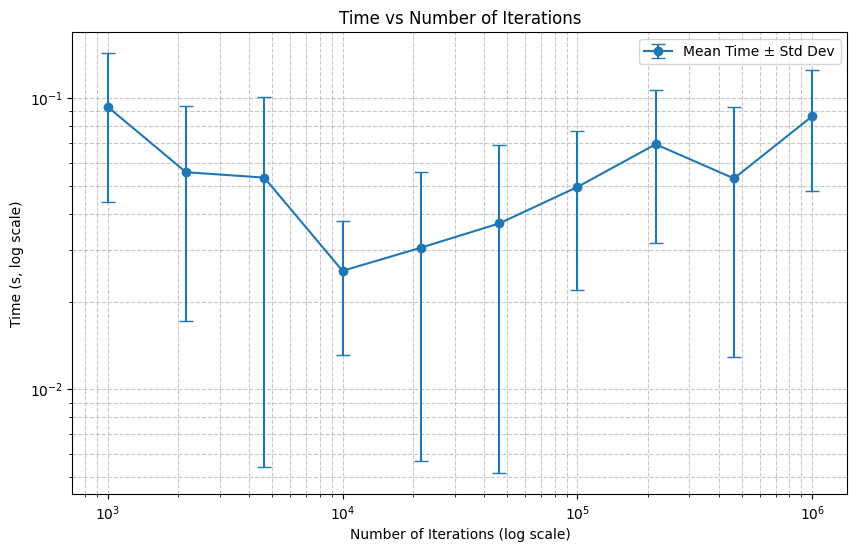

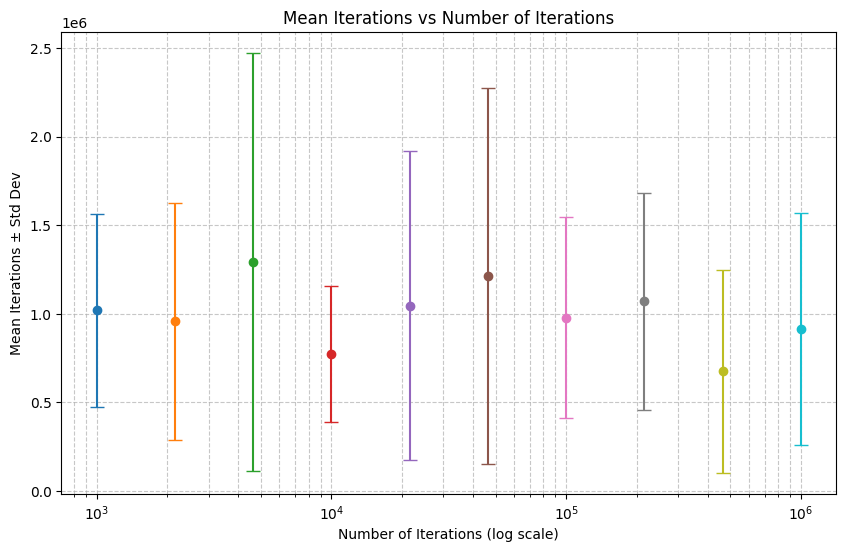

In [ ]:
def plot_times_vs_iterations(timing_results):
    n_iterations = list(timing_results.keys())
    times = [timing_results[n]['time_mean_s'] for n in n_iterations]
    time_stds = [timing_results[n]['time_std_s'] for n in n_iterations]

    plt.figure(figsize=(10, 6))
    plt.errorbar(n_iterations, times, yerr=time_stds, fmt='o-', capsize=5, label='Mean Time ± Std Dev')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Iterations (log scale)")
    plt.ylabel("Time (s, log scale)")
    plt.title("Time vs Number of Iterations")
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
def plot_iterations_vs_nit(timing_results):
    plt.figure(figsize=(10, 6))
    for n_it, stats in timing_results.items():
        plt.errorbar(
            [n_it], [stats['iters_mean']],
            yerr=[stats['iters_std']],
            fmt='o', capsize=5
        )
    
    plt.xscale('log')
    plt.xlabel("Number of Iterations (log scale)")
    plt.ylabel("Mean Iterations ± Std Dev")
    plt.title("Mean total Iterations vs Number of Iterations per chunk")
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.show()

plot_times_vs_iterations(timing_results)
plot_iterations_vs_nit(timing_results)

In [65]:
dict = simulate_path(
            start_point=(0,0),
            p=[0, 0.25, 0.25, 0.25, 0.25],
            n_it_per=1000,
            n_runs=10,
            boundary=10000,
            trajectory=False,
            multiply_factor=10
)

In [68]:
print(f"{dict['final_position']}, {dict['iterations']}")
print(np.sqrt(dict["final_position"][0]**2 + dict["final_position"][1]**2))

(np.int64(1800), np.int64(9840)), 424000
10003.279462256365


In [61]:
n=500
x = []
y = []
k = []
for _ in range(n):
    
    dict = simulate_path(
            start_point=(0,0),
            p=[0, 0.25, 0.25, 0.25, 0.25],
            n_it_per=1000000,
            boundary=10000,
            trajectory=False,
            multiply_factor=10
        )
    x.append(dict['final_position'][0])
    y.append(dict['final_position'][1])
    k.append(dict['iterations'])
    
    


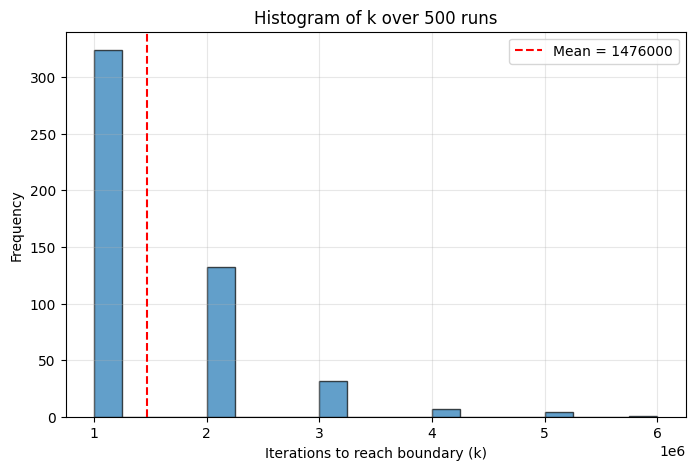

In [62]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.hist(k, bins=20, color='C0', edgecolor='k', alpha=0.7)
plt.axvline(np.mean(k), color='red', linestyle='--', label=f"Mean = {np.mean(k):.0f}")
plt.xlabel("Iterations to reach boundary (k)")
plt.ylabel("Frequency")
plt.title(f"Histogram of k over {len(k)} runs")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [47]:
print(f"Average number of iterations over {n} runs: {np.mean(x)}, {np.mean(k)}")
print(x)

Average number of iterations over 100 runs: -771.0, 1108000.0
[np.int64(-9530), np.int64(-870), np.int64(370), np.int64(-6030), np.int64(-6910), np.int64(9760), np.int64(-8930), np.int64(-9650), np.int64(8480), np.int64(-9580), np.int64(-4220), np.int64(-3830), np.int64(7800), np.int64(9740), np.int64(2180), np.int64(10000), np.int64(-8500), np.int64(9690), np.int64(-6860), np.int64(-9250), np.int64(4860), np.int64(-9950), np.int64(9720), np.int64(9840), np.int64(9470), np.int64(-9790), np.int64(8610), np.int64(5370), np.int64(9890), np.int64(-9680), np.int64(-9410), np.int64(590), np.int64(-9110), np.int64(-7030), np.int64(-9350), np.int64(2660), np.int64(3340), np.int64(-9510), np.int64(-9160), np.int64(-9110), np.int64(-630), np.int64(1190), np.int64(-7210), np.int64(-8860), np.int64(1610), np.int64(-5090), np.int64(-3550), np.int64(2990), np.int64(-5000), np.int64(4130), np.int64(-8940), np.int64(10000), np.int64(-9940), np.int64(1870), np.int64(-7590), np.int64(-6270), np.int64(-6